# Validation ideas

In [29]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import mode
import plotly.express as px
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

import warnings
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import mode, entropy
from scipy.signal import butter, filtfilt
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids

In [30]:
final_df= pd.read_csv('C:\\Users\\rogal\\UczenieMaszynowe\\Projekt2\\csv_do_walidacji.csv', index_col=None)  #ramka do walidacji

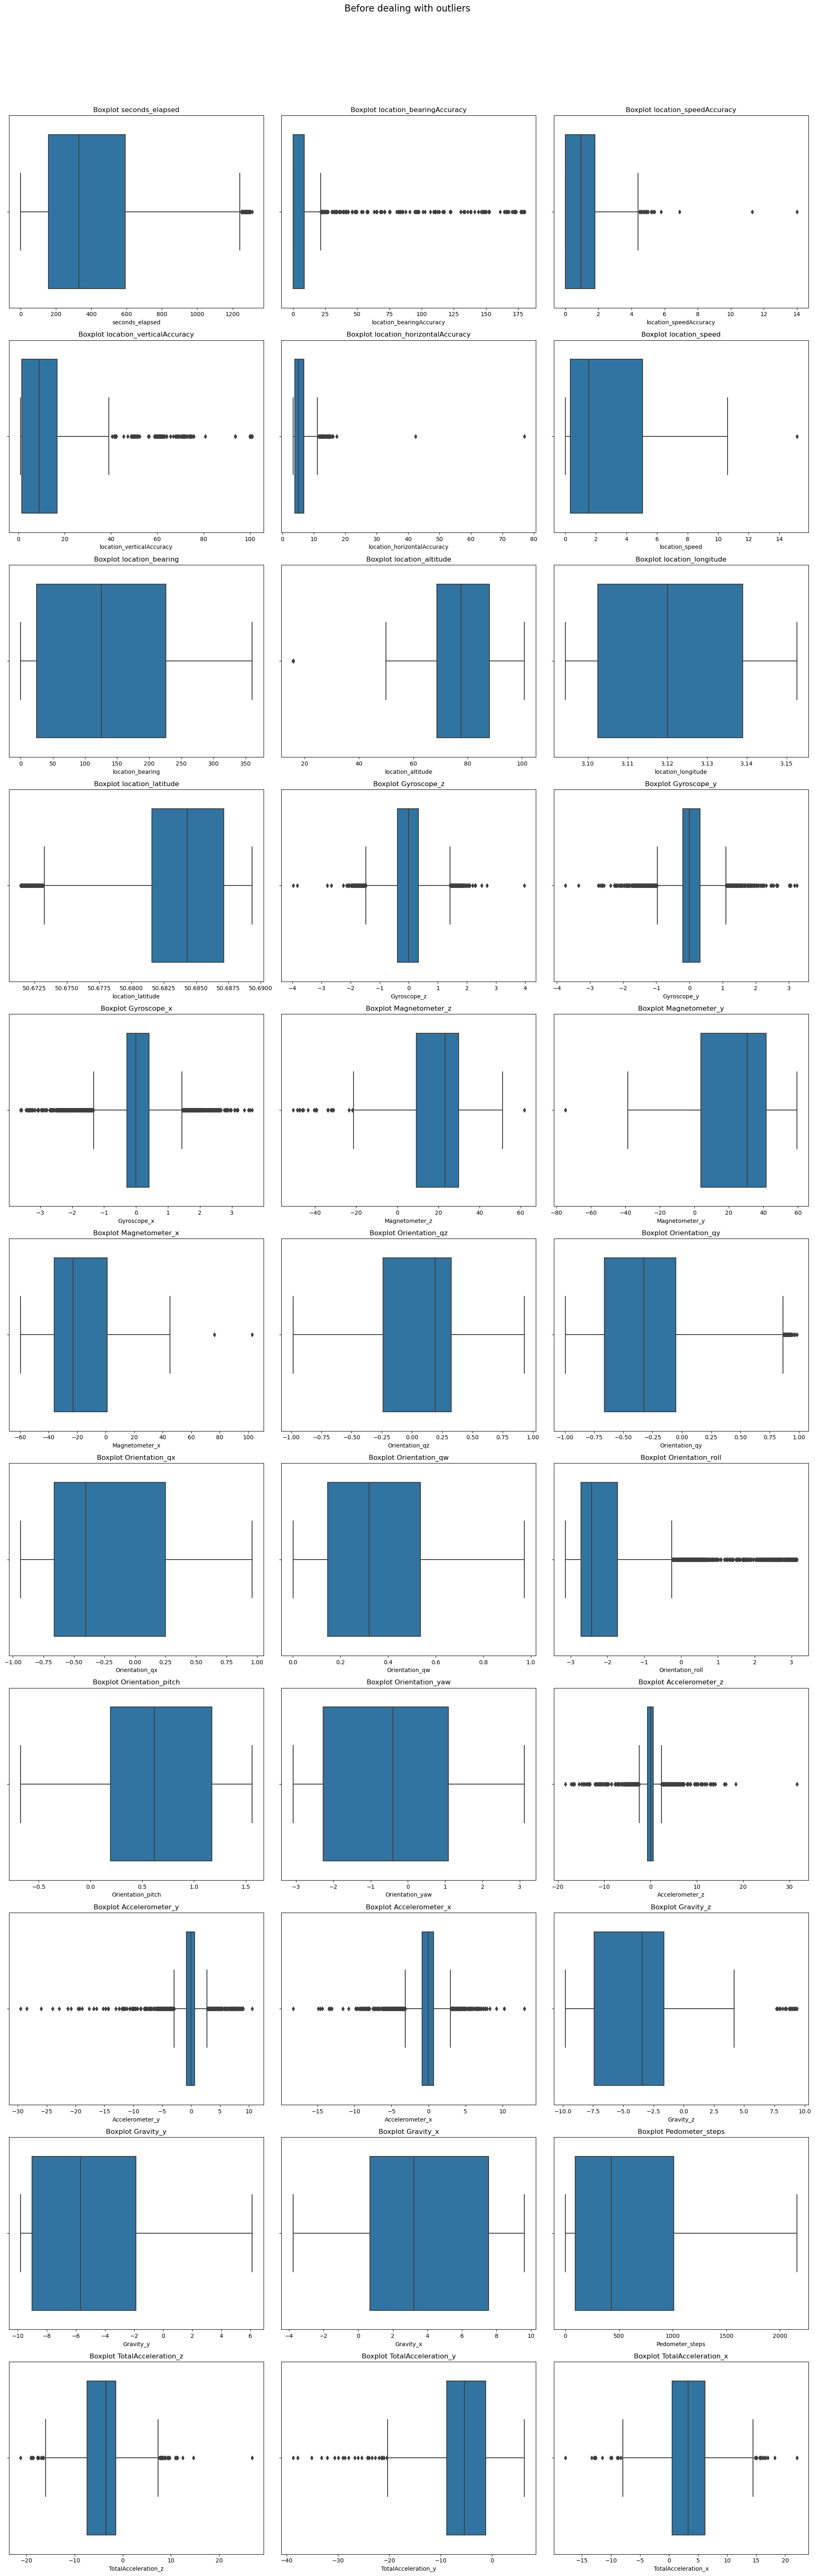

In [31]:
def plot_boxplots(df, cols_per_row=3, title="Boxplots"):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols = len(numeric_cols)
    num_rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)

    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(20, 6 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=df[col].dropna(), ax=axes[i])
        axes[i].set_title(f'Boxplot {col}')

    # Wyłącz puste osie
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_boxplots(final_df, title="Before dealing with outliers")

<span style="color:orange;">Wnioski dla ramki testowej lekko inne - kolumna seconds_elapsed też ma dużo outlierów</span>

In [32]:
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))



cap_outliers_iqr(final_df, 'location_verticalAccuracy')
cap_outliers_iqr(final_df, 'location_speedAccuracy')
cap_outliers_iqr(final_df, 'location_horizontalAccuracy')
cap_outliers_iqr(final_df, 'location_bearingAccuracy')
cap_outliers_iqr(final_df, 'location_latitude')
cap_outliers_iqr(final_df, 'Gyroscope_z')
cap_outliers_iqr(final_df, 'Gyroscope_y')
cap_outliers_iqr(final_df, 'Gyroscope_x')
cap_outliers_iqr(final_df, 'Magnetometer_z')
cap_outliers_iqr(final_df, 'Orientation_qy')
cap_outliers_iqr(final_df, 'Orientation_roll')
cap_outliers_iqr(final_df, 'Accelerometer_z')
cap_outliers_iqr(final_df, 'Accelerometer_y')
cap_outliers_iqr(final_df, 'Accelerometer_x')
cap_outliers_iqr(final_df, 'Gravity_z')
cap_outliers_iqr(final_df, 'TotalAcceleration_y')
cap_outliers_iqr(final_df, 'TotalAcceleration_x')
cap_outliers_iqr(final_df, 'TotalAcceleration_z')
#dodanie tu jeszcze kolumny w których zostały pojedyncze outliery
cap_outliers_iqr(final_df, 'seconds_elapsed')
cap_outliers_iqr(final_df, 'Magnetometer_x')
cap_outliers_iqr(final_df, 'Magnetometer_y')
cap_outliers_iqr(final_df, 'location_speed')
cap_outliers_iqr(final_df, 'location_altitude')

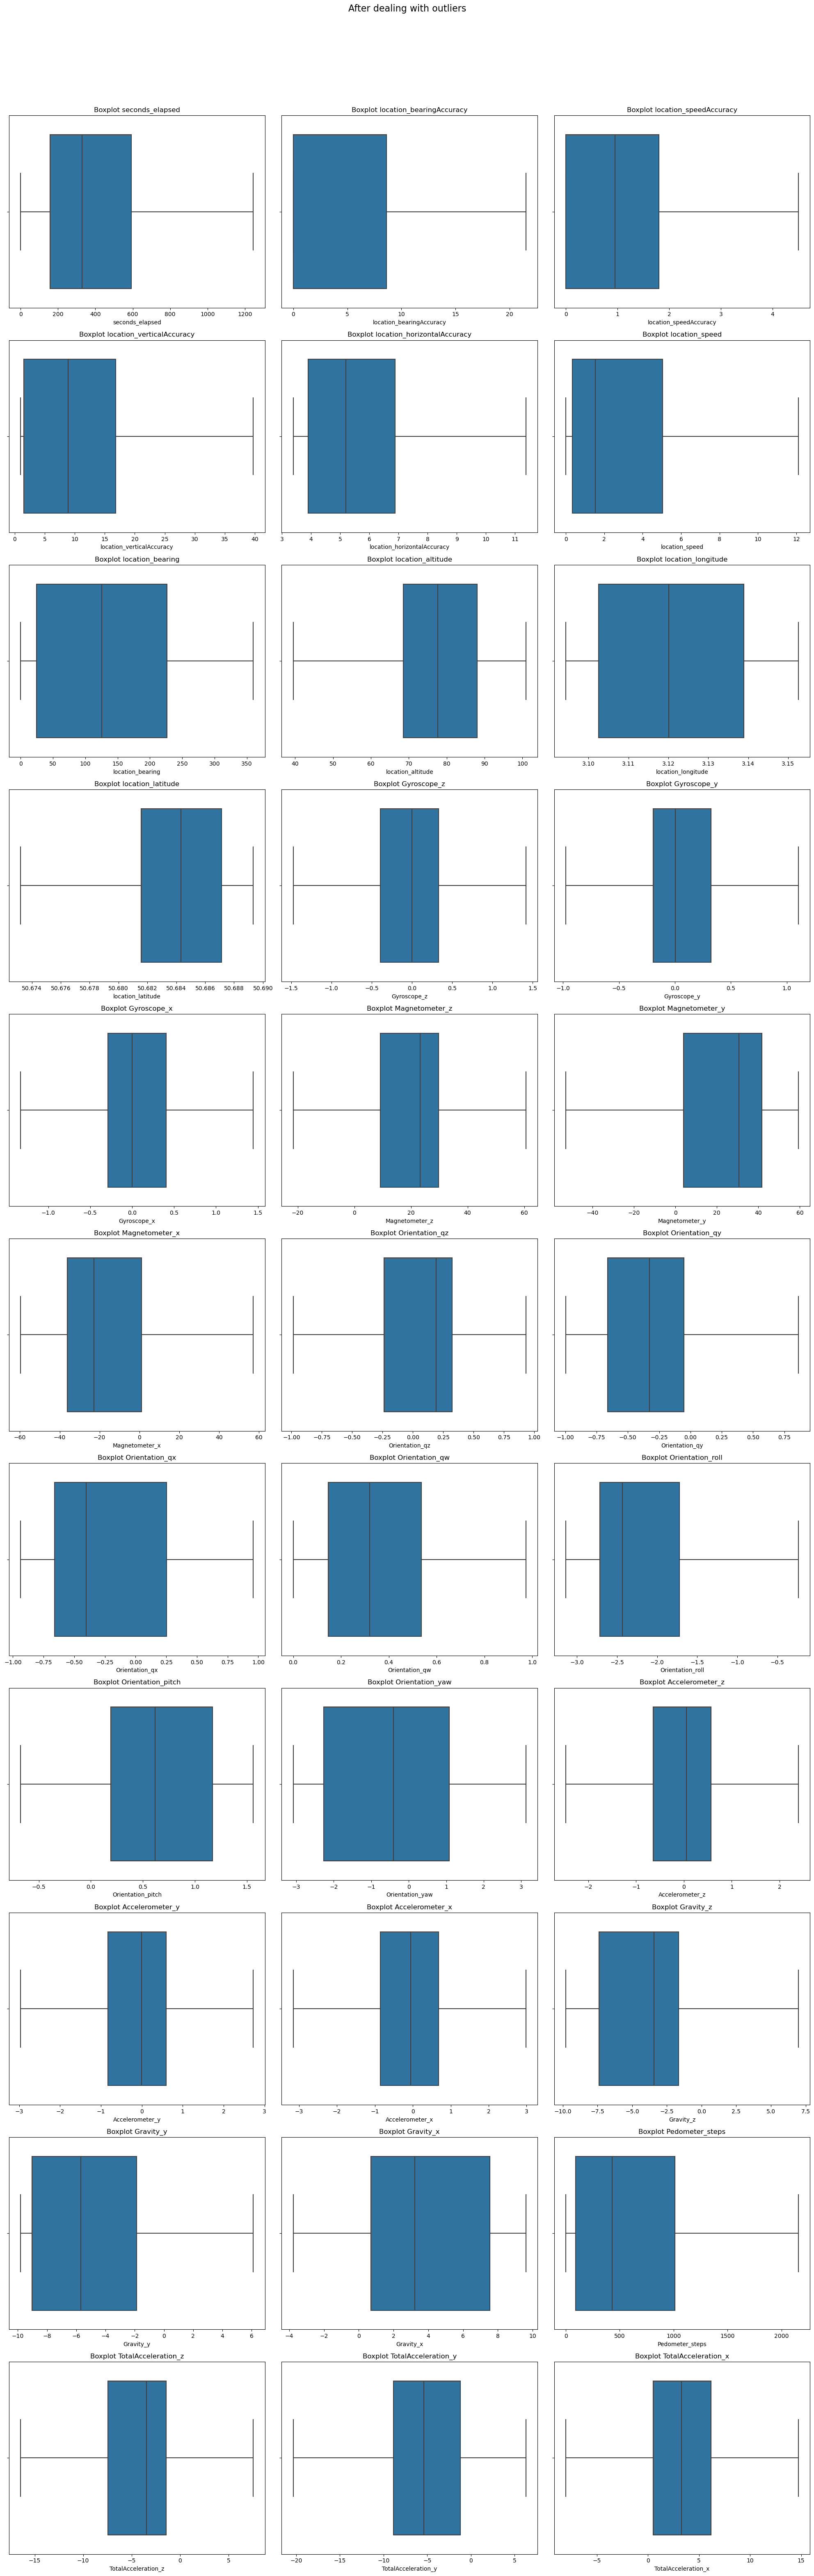

In [33]:
plot_boxplots(final_df, title="After dealing with outliers")

<span style="color:purple;">Uwaga odnośnie kodu: jest bardzo dużo dodawania i usuwania nowych kolumn. Dobrze byłoby pomyśleć o Pipeline</span>

Przekopiowanie kodu, aby mieć te same nowe kolumny do dalszej analizy:

In [34]:
final_df['pitch_roll_ratio'] = final_df['Orientation_pitch'] / final_df['Orientation_roll']
final_df['pitch_yaw_ratio'] = final_df['Orientation_pitch'] / final_df['Orientation_yaw']
final_df['roll_yaw_ratio'] = final_df['Orientation_roll'] / final_df['Orientation_yaw']

# Tworzenie bezwzględnych wartości stosunków
final_df['abs_pitch_roll_ratio'] = abs(final_df['pitch_roll_ratio'])
final_df['abs_pitch_yaw_ratio'] = abs(final_df['pitch_yaw_ratio'])
final_df['abs_roll_yaw_ratio'] = abs(final_df['roll_yaw_ratio'])

# Tworzenie różnic kątów
final_df['pitch_roll_diff'] = final_df['Orientation_pitch'] - final_df['Orientation_roll']
final_df['pitch_yaw_diff'] = final_df['Orientation_pitch'] - final_df['Orientation_yaw']
final_df['roll_yaw_diff'] = final_df['Orientation_roll'] - final_df['Orientation_yaw']
final_df['acceleration_magnitude'] = np.sqrt(final_df['Accelerometer_x']**2 + final_df['Accelerometer_y']**2 + final_df['Accelerometer_z']**2)
def calculate_rms(series):
    return np.sqrt(np.mean(series**2))

def calculate_energy(series):
    return np.sum(series**2)

window_size = 3

def calculate_rolling_features(df, sensor_prefix, window_size):
    rolling_features = pd.DataFrame(index=df.index)
    for axis in ['x', 'y', 'z']:
        column_name = f'{sensor_prefix}_{axis}'
        rolling_features[f'rms_{sensor_prefix}_{axis}'] = df[column_name].rolling(window=window_size, min_periods=1).apply(calculate_rms, raw=True)
        rolling_features[f'energy_{sensor_prefix}_{axis}'] = df[column_name].rolling(window=window_size, min_periods=1).apply(calculate_energy, raw=True)
    return rolling_features

# Lista sensorów
sensors = ['Accelerometer', 'Gravity', 'Gyroscope', 'Magnetometer']

# Obliczanie cech ruchomych dla każdego sensora i osi
for sensor in sensors:
    rolling_features = calculate_rolling_features(final_df, sensor, window_size)
    final_df = pd.concat([final_df, rolling_features], axis=1)
def low_pass_filter(data, cutoff_freq, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Definicja filtru pasmowego
def band_pass_filter(data, low_cutoff, high_cutoff, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Parametry filtru
cutoff_freq = 1.0  # Częstotliwość odcięcia
sampling_rate = 10.0  # Częstotliwość próbkowania

low_cutoff = 0.5  # Dolna częstotliwość odcięcia
high_cutoff = 3.0  # Górna częstotliwość odcięcia

# Filtracja danych akcelerometru i żyroskopu oraz tworzenie DataFrame z wynikami
filtered_columns = {
    'Filtered_Accelerometer_x': low_pass_filter(final_df['Accelerometer_x'], cutoff_freq, sampling_rate),
    'Filtered_Accelerometer_y': low_pass_filter(final_df['Accelerometer_y'], cutoff_freq, sampling_rate),
    'Filtered_Accelerometer_z': low_pass_filter(final_df['Accelerometer_z'], cutoff_freq, sampling_rate),
    'Filtered_Gyroscope_x': low_pass_filter(final_df['Gyroscope_x'], cutoff_freq, sampling_rate),
    'Filtered_Gyroscope_y': low_pass_filter(final_df['Gyroscope_y'], cutoff_freq, sampling_rate),
    'Filtered_Gyroscope_z': low_pass_filter(final_df['Gyroscope_z'], cutoff_freq, sampling_rate),
    'Bandpass_Accelerometer_x': band_pass_filter(final_df['Accelerometer_x'], low_cutoff, high_cutoff, sampling_rate),
    'Bandpass_Accelerometer_y': band_pass_filter(final_df['Accelerometer_y'], low_cutoff, high_cutoff, sampling_rate),
    'Bandpass_Accelerometer_z': band_pass_filter(final_df['Accelerometer_z'], low_cutoff, high_cutoff, sampling_rate),
    'Bandpass_Gyroscope_x': band_pass_filter(final_df['Gyroscope_x'], low_cutoff, high_cutoff, sampling_rate),
    'Bandpass_Gyroscope_y': band_pass_filter(final_df['Gyroscope_y'], low_cutoff, high_cutoff, sampling_rate),
    'Bandpass_Gyroscope_z': band_pass_filter(final_df['Gyroscope_z'], low_cutoff, high_cutoff, sampling_rate)
}

# Tworzenie DataFrame z przefiltrowanymi kolumnami
filtered_df = pd.DataFrame(filtered_columns)

# Łączenie przefiltrowanych kolumn z oryginalnym DataFrame
final_df = pd.concat([final_df, filtered_df], axis=1)
final_df['avg_steps_per_minute']= final_df['Pedometer_steps']/final_df['seconds_elapsed'] * 60
# Definicja funkcji przypisującej kategorie `bearing`
def categorize_bearing(bearing):
    if 0 <= bearing < 90:
        return 'north'
    elif 90 <= bearing < 180:
        return 'east'
    elif 180 <= bearing < 270:
        return 'south'
    else:
        return 'west'

# Przypisanie kategorii `bearing`
final_df['bearing_category'] = final_df['location_bearing'].apply(categorize_bearing)

# One-hot encoding dla `bearing_category`
final_df = pd.get_dummies(final_df, columns=['bearing_category'], prefix='bearing')
final_df['combined_orientation'] = final_df[['Orientation_yaw', 'pitch_yaw_diff', 'roll_yaw_diff']].mean(axis=1)
final_df.drop(columns=['Pedometer_steps'], inplace=True)
final_df.drop(columns=['abs_pitch_roll_ratio'], inplace=True)
final_df.drop(columns=['Orientation_yaw', 'pitch_yaw_diff', 'roll_yaw_diff'], inplace=True)
columns_to_drop = [col for col in final_df.columns if col.startswith('rms')]
final_df.drop(columns=columns_to_drop, inplace=True)
final_df['Total_Motion_Intensity'] = (final_df['Gravity_y']**2 + final_df['Magnetometer_y']**2 + final_df['TotalAcceleration_y']**2)**0.5
final_df['Gravity_Magnetometer_y_interaction'] = final_df['Gravity_y'] * final_df['Magnetometer_y']
final_df['Gravity_Orientation_pitch_ratio'] = final_df['Gravity_y'] / (final_df['Orientation_pitch'] + 1e-6)
if 'label' in final_df.columns:
    final_df.drop(columns=['label'], inplace=True)

if 'time' in final_df.columns:
    final_df.drop(columns=['time'], inplace=True)

<span style="color:orange;">Grupa budowania sprawdza teraz rozkład zmiennych przed starndaryzacją. Sprawdźmy, jak wyglądają wariancje - może pomoże to później przy wyborze cech</span>

Series([], dtype: float64)


<Axes: >

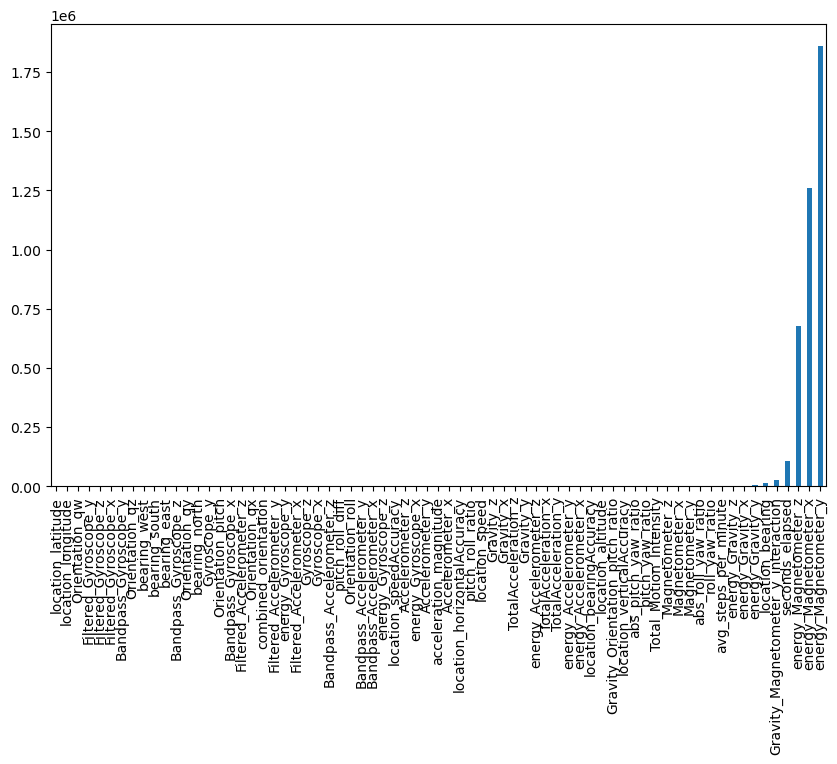

In [35]:
variances = final_df.var()
#sprawdzamy czy jakieś kolumny mają zerowe wariancje
zero_variances = variances[variances == 0]
print(zero_variances) #nie ma zerowych wariancji
sorted_variances = variances.sort_values() # pokazujemy na wykresie - słabo widać, zle widzimy, że kolumny z przedrostkiem 'energy' najwieksze, a location i filtered najmniejsze
plt.figure(figsize=(10, 6))
sorted_variances.plot(kind='bar')

# Standaryzacja

spróbujmy wywołać ten kod ale standaryzując też kolumny binarne - zobaczymy czy otrzymamy lepsze wyniki w PCA

In [36]:
columns_to_scale = [col for col in final_df.columns if col != 'time']

final_df_copy = final_df.copy() #Will be needed for last section of this step

scaler = StandardScaler()
final_df[columns_to_scale] = scaler.fit_transform(final_df[columns_to_scale])

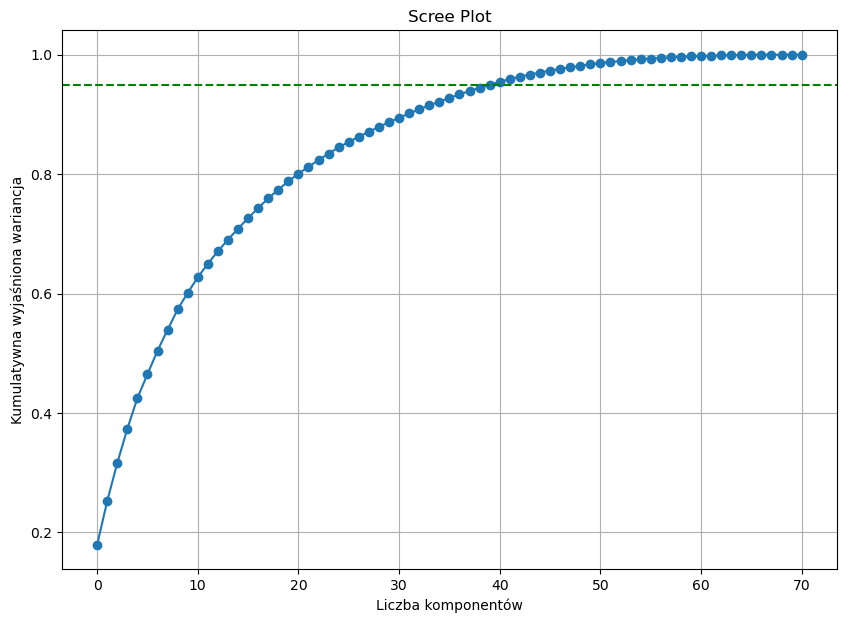

Komponent 1: 0.1793 wyjaśnionej wariancji
Komponent 2: 0.2522 wyjaśnionej wariancji
Komponent 3: 0.3162 wyjaśnionej wariancji
Komponent 4: 0.3734 wyjaśnionej wariancji
Komponent 5: 0.4248 wyjaśnionej wariancji
Komponent 6: 0.4650 wyjaśnionej wariancji
Komponent 7: 0.5042 wyjaśnionej wariancji
Komponent 8: 0.5394 wyjaśnionej wariancji
Komponent 9: 0.5735 wyjaśnionej wariancji
Komponent 10: 0.6013 wyjaśnionej wariancji
Komponent 11: 0.6270 wyjaśnionej wariancji
Komponent 12: 0.6500 wyjaśnionej wariancji
Komponent 13: 0.6709 wyjaśnionej wariancji
Komponent 14: 0.6903 wyjaśnionej wariancji
Komponent 15: 0.7088 wyjaśnionej wariancji
Komponent 16: 0.7262 wyjaśnionej wariancji
Komponent 17: 0.7434 wyjaśnionej wariancji
Komponent 18: 0.7592 wyjaśnionej wariancji
Komponent 19: 0.7741 wyjaśnionej wariancji
Komponent 20: 0.7881 wyjaśnionej wariancji
Komponent 21: 0.8007 wyjaśnionej wariancji
Komponent 22: 0.8124 wyjaśnionej wariancji
Komponent 23: 0.8235 wyjaśnionej wariancji
Komponent 24: 0.8345

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Zakładamy, że final_df jest już załadowany i przetworzony, a final_df_scaled jest standaryzowanym DataFrame

# Oblicz PCA na pełnym zestawie danych
pca = PCA().fit(final_df)

# Wykres "scree plot"
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='g', linestyle='--') 
plt.xlabel('Liczba komponentów')
plt.ylabel('Kumulatywna wyjaśniona wariancja')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Wydrukuj wyjaśnioną wariancję dla poszczególnych komponentów
explained_variance = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(explained_variance):
    print(f"Komponent {i+1}: {var:.4f} wyjaśnionej wariancji")

W tym przypadku skalowanie kolumn binarnych nie poprawiło PCA

# Modelowanie wstępne

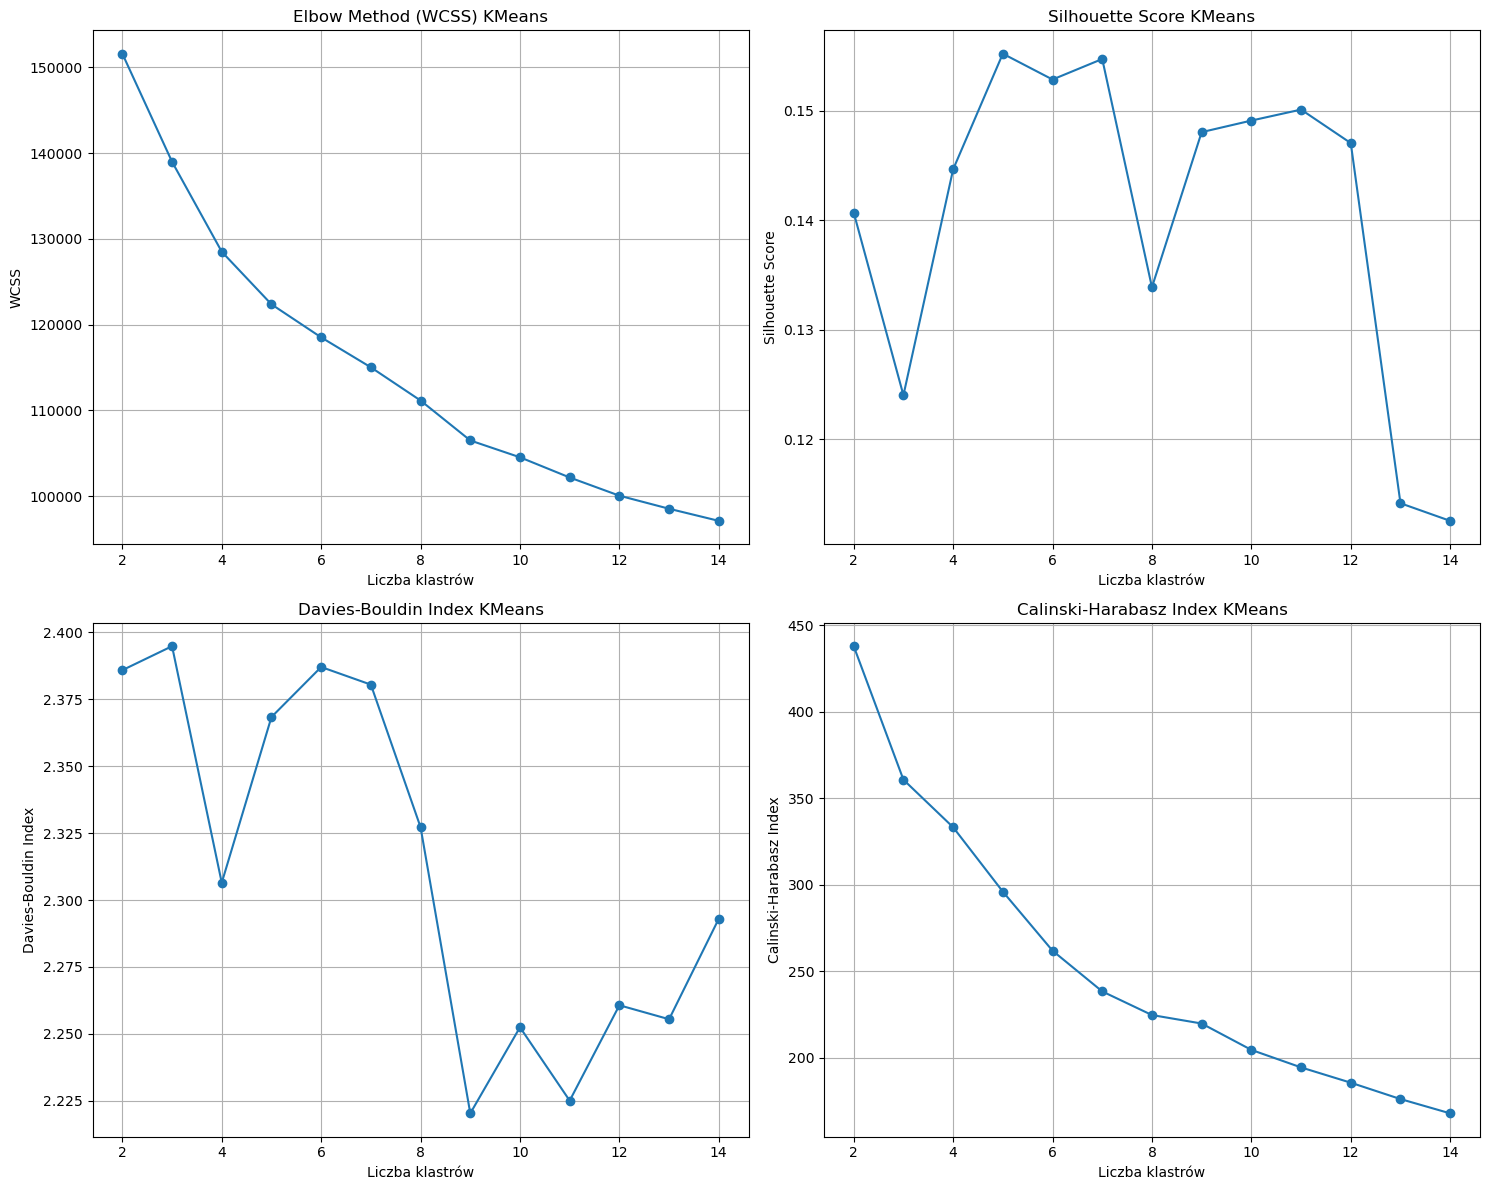

In [38]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

n_components= 35

pca = PCA(n_components=n_components)
final_df_pca = pca.fit_transform(final_df)
pca_columns = [f'PCA{i+1}' for i in range(n_components)]
final_df_pca = pd.DataFrame(final_df_pca, columns=pca_columns)
# Listy do przechowywania wyników
wcss = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Obliczanie metryk dla różnych liczby klastrów
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    labels = kmeans.fit_predict(final_df_pca)
    
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(final_df_pca, labels))
    davies_bouldin_scores.append(davies_bouldin_score(final_df_pca, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(final_df_pca, labels))

# Wykresy wszystkich metryk
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# WCSS
axs[0, 0].plot(range(2, 15), wcss, marker='o')
axs[0, 0].set_xlabel('Liczba klastrów')
axs[0, 0].set_ylabel('WCSS')
axs[0, 0].set_title('Elbow Method (WCSS) KMeans')
axs[0, 0].grid(True)

# Silhouette Score
axs[0, 1].plot(range(2, 15), silhouette_scores, marker='o')
axs[0, 1].set_xlabel('Liczba klastrów')
axs[0, 1].set_ylabel('Silhouette Score')
axs[0, 1].set_title('Silhouette Score KMeans')
axs[0, 1].grid(True)

# Davies-Bouldin Index
axs[1, 0].plot(range(2, 15), davies_bouldin_scores, marker='o')
axs[1, 0].set_xlabel('Liczba klastrów')
axs[1, 0].set_ylabel('Davies-Bouldin Index')
axs[1, 0].set_title('Davies-Bouldin Index KMeans')
axs[1, 0].grid(True)

# Calinski-Harabasz Index
axs[1, 1].plot(range(2, 15), calinski_harabasz_scores, marker='o')
axs[1, 1].set_xlabel('Liczba klastrów')
axs[1, 1].set_ylabel('Calinski-Harabasz Index')
axs[1, 1].set_title('Calinski-Harabasz Index KMeans')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

Może warto dodać metryki takie jak na Lab 9 :

In [51]:
from scipy.spatial import distance
#functions from Lab9 for minimal distance between clusters and distance to center
def min_interclust_dist(df, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(df[cluster_i_idx], df[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

<span style="color:orange;">Sprawdzenie czy dla innej liczby klastrów może będzie lepiej:</span>

In [57]:
n_components= 21

pca = PCA(n_components=n_components)
final_df_pca_21_components = pca.fit_transform(final_df)

# Konwersja wyniku z powrotem do DataFrame
pca_columns = [f'PCA{i+1}' for i in range(n_components)]
final_df_pca_21_components = pd.DataFrame(final_df_pca_21_components, columns=pca_columns)
pca_df_21_components = pd.DataFrame(final_df_pca_21_components, columns=[f'PCA{i+1}' for i in range(21)])

# Klasteryzacja KMeans dla różnych liczby klastrów
cluster_counts = {
    'elbow_method_kmedoids': 4,
    'silhouette_score_kmedoids': 5,
    'davies_bouldin_kmedoids': 4,
    'calinski_harabasz_kmedoids': 4
}
def evaluate_clustering(X, labels):
    scores = {
        'Silhouette Score': silhouette_score(X, labels),
        'Davies-Bouldin Index': davies_bouldin_score(X, labels),
        'Calinski-Harabasz Index': calinski_harabasz_score(X, labels)
    }
    return scores

# Tworzenie kolumn z klasteryzacją dla każdej metryki
for method, n_clusters in cluster_counts.items():
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(final_df_pca_21_components)
    pca_df_21_components[f'clusters_{method}'] = clusters

# Ocena wyników klasteryzacji dla każdej metryki
results = []

for method in cluster_counts.keys():
    clusters = pca_df_21_components[f'clusters_{method}']
    scores = evaluate_clustering(final_df_pca_21_components, clusters)
    results.append((method, scores))

# Wyświetlenie wyników
results_df = pd.DataFrame(results, columns=['Method', 'Scores'])
results_df['Silhouette Score'] = results_df['Scores'].apply(lambda x: x['Silhouette Score'])
results_df['Davies-Bouldin Index'] = results_df['Scores'].apply(lambda x: x['Davies-Bouldin Index'])
results_df['Calinski-Harabasz Index'] = results_df['Scores'].apply(lambda x: x['Calinski-Harabasz Index'])
results_df = results_df.drop(columns=['Scores'])

In [58]:
results_df

,Method,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,elbow_method_kmedoids,0.171749,2.087543,404.880547
1,silhouette_score_kmedoids,0.183983,2.153419,362.952464
2,davies_bouldin_kmedoids,0.171749,2.087543,404.880547
3,calinski_harabasz_kmedoids,0.171749,2.087543,404.880547


Wyniki raczej takie same, tylko Caliński się różni

<span style="color:purple">Na tym etapie walidowaliśmy inżynierię cech i wstępne modelowanie. Wyniki w metrykach testowanych przez grupę budującą nie są zadowalające, lecz podobne do tych otrzymanych przez nas na ramce testowej. Powyżej sprawdziliśmy kilka rzeczy, które myśleliśmy, że mogą polepszyć wyniki, niestety resultaty były podobne jak i wcześniej. Nasze sugestie do grupy budującej na tym etapie to:

* może warto zrobić kilka ramek z różnymi podzbiorami cech, na których można testować modele
* dotychczas nie było dostosowywania parametrów, może GridSeach by coś zmienił
* napisanie swoich własnych metryk zgodnie z celem biznesowym 